# Estimate rates from SqRA rate matrix 1D

In [1]:
import copy
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg

### Adjacency matrix

In [2]:
def adjancency_matrix_sparse(nbins, nd, periodic=False):
    v = np.zeros(nbins)
    v[1] = 1
    
    if periodic:
        v[-1] = 1
        A0 = scipy.sparse.csc_matrix(scipy.linalg.circulant(v)) #.toarray()
    else:
        A0 = scipy.sparse.csc_matrix(scipy.linalg.toeplitz(v)) #.toarray()
    
    A = A0
    I2 = scipy.sparse.eye(nbins)  #np.eye(nbins)
    for _ in range(1, nd):
        I1 = scipy.sparse.eye(*A.shape) #np.eye(*A.shape)
        A =  scipy.sparse.kron(A0, I1) + scipy.sparse.kron(I2, A)
    return A

### Spatial discretization (ref: http://www-cs-students.stanford.edu/~amitp/game-programming/polygon-map-generation/)

1. Randomly select your points
2. Compute midways between your points
    -> The two midways on the two sides of each point, is like
       its Voronoi polygon in the Voronoi diagram
    -> So let's call the range between these two "midways" a Voronoi range!
3. Replace each point by the center of its Voronoi range
4. If you want the values to be less random, loop back to step 2
5. The ranges you are looking for are the Voronoi ranges of the last results.

In [5]:
def find_mid(sorted_list):
        acopy = sorted(sorted_list * 2)[1:-1]
        mid = [acopy[j]+((acopy[j+1]-acopy[j])/2) for j in range(0, len(acopy),2)]
        return mid

def generating_bins(E_pot,nedges, loop=2):
    # increase loop to have less random discretization
    random_float = sorted([np.random.uniform(min(E_pot), max(E_pot)) for i in range(nedges)])
    counter = loop
    bins = None
    
    while counter != 0:
        if counter == loop:
            midpoints = find_mid(random_float)
        else:
            edge = find_mid(bins)
            midpoints = find_mid(edge)
        bins = [min(E_pot)] + copy.deepcopy(midpoints) + [max(E_pot)]
        counter -= 1
        
    return bins

## 1D system

In [3]:
# Potential energy function
def v1d(x):
    return (x**2 - 1)**2 

# System parameters
kB    = 0.008314463
T     = 300
mass  = 1
gamma = 1
D     = kB * T / mass / gamma # diffusion coefficient
sigma = np.sqrt(2 * D) # diagonal matrix
beta  = 1 / kB / T

# Grid
nd     = 1  # Number of dimensions
nedges = 60 # State boundaries
xmin   = -2.8
xmax   =  2.8

x      = np.linspace(xmin, xmax, nedges)  # array with x edges
dx     = x[1] - x[0]
x      = x[:-1] + (dx / 2)                # array with x centers
xbins  = nedges - 1
Nbins  = xbins**nd                        # number of bins

#### Build SqRA 1D

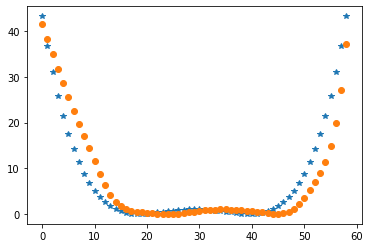

In [6]:
A  = adjancency_matrix_sparse(Nbins, nd, periodic=False)

# Potential energy of states
#v = v1d(x)
#x1 = np.array([min(x)] + find_mid(generating_bins(x, nedges, loop = 10)) + [max(x)])
x1 = np.array(find_mid(generating_bins(x, xbins, loop = 10)))
v = v1d(x1)


# Flux
flux = D / dx**2 # Normalisation of Fick's second law?
Af   = flux * A 

# Diagonalization
SQRA = np.sqrt(np.exp(- beta * v)) # What happen to the partition function ?
SQRA = SQRA / sum(SQRA) # Normalized arithmetic mean of Boltzman density values of points in each Voronoi region
Di   = scipy.sparse.spdiags(SQRA, 0, Nbins, Nbins) # right eigenvector of Q''_c with eigenvalues close to 0
D1   = scipy.sparse.spdiags(1/SQRA, 0, Nbins, Nbins)       
Q    = D1 * Af * Di # basis transformation

Q    = Q + scipy.sparse.spdiags(-Q.sum(axis=1).T, 0, Nbins, Nbins) # compute diagonal elements of Q
eigenval, eigenvec = scipy.sparse.linalg.eigs(Q.T, 4, which='LR')
plt.plot(v1d(x),'*')
plt.plot(v,'o')

#### Estimate rate from xA = -1 to xB = +1

(59, 59)
Rate from A to B:  0.7742244032391836


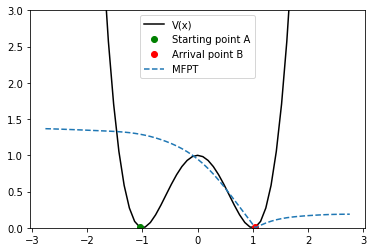

In [7]:
iA = np.argwhere(np.abs(x + 1) < 0.05).item() # index of xA
iB = np.argwhere(np.abs(x - 1) < 0.05).item() # index of xB

xA = x[iA]
xB = x[iB]

Q1         = scipy.sparse.csr_matrix.copy(Q)
Q1         = Q1.toarray()
Q1[iB, :]  = 0.0
Q1[iB, iB] = -1.0
b          = -np.ones(xbins)
b[iB]      = 0.0
m_t        = np.linalg.solve(Q1, b)
k          = 1./m_t[iA]
print('Rate from A to B: ', k)
 
plt.plot(x, v1d(x),'k',label='V(x)')
plt.plot(xA, v1d(xA), 'go',label='Starting point A')
plt.plot(xB, v1d(xB), 'ro',label='Arrival point B')
plt.plot(x,m_t,'--',label='MFPT')
plt.ylim((0,3))
plt.legend()

#### Estimate rate from set A = [-1.2, -0.7] to set B = [0.8, 1.3]

Rate from set A to set B:  0.8760825533337239


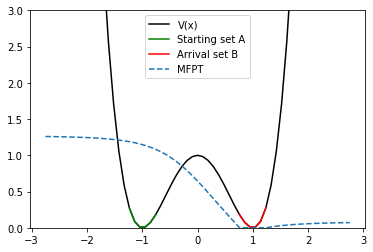

In [ ]:
iAa = np.argwhere(np.abs(x + 1.2) < 0.05).item() # first index of set A
iAb = np.argwhere(np.abs(x + 0.7) < 0.05).item() # last index of set A

iBa = np.argwhere(np.abs(x - 0.8) < 0.05).item() # first index of set B
iBb = np.argwhere(np.abs(x - 1.3) < 0.05).item() # last index of set B

setA = np.arange(iAa,iAb)
setB = np.arange(iBa,iBb)

xA = x[setA]
xB = x[setB]

W   = np.exp(- beta * v)
W   = W[setA]
W   = W / np.sum(W)

Q2                   = scipy.sparse.csr_matrix.copy(Q)
Q2                   = Q2.toarray()
Q2[iBa:iBb, :]       = 0.0
Q2[iBa:iBb, iBa:iBb] = -np.eye(len(setB))

b              = -np.ones(len(Q2))
b[setB]        = 0.0
m_t            = np.linalg.solve(Q2, b)  #Mean first-passage time to set right (for all possible starting states)
m_t_sets       = np.dot(W, m_t[setA])    #Mean first-passage time from set left to set right

k              = 1./m_t_sets
print('Rate from set A to set B: ', str(k))

plt.plot(x, v1d(x),'k',label='V(x)')
plt.plot(xA, v1d(xA), 'g',label='Starting set A')
plt.plot(xB, v1d(xB), 'r',label='Arrival set B')
plt.plot(x,m_t,'--',label='MFPT')
plt.ylim((0,3))
plt.legend()